![banner](../../../src/visuals/banner.png)

# Variational AutoEncoders: Compact Compressions are Even Better Friends!

As we had shown previously, AutoEncoders are an extremely effective way for mapping high dimensional and complex datasets to lower dimensional latents. There were again two parts to an AutoEncoder:
- Encoder: Take data and compress down to the lower dimensional form
- Decoder: Take the lower dimensional data and attempt to reconstruct the original uncompressed data

If all you care about is encoding, then this method is probably sufficient. You can definitely write larger and more complex AutoEncoders but the prinipals from our explorations stay the same. On the other hand, what if you want to generate new samples?

### What are Generative Models?

There are typically two classes of models. Discriminative Models are typically architectures that take in data and predict something about it like a classification or regression task. More specifically, this means discriminative models are learning something along the lines of $P(y=prediction|x=data)$, to predict the probabilty of some output y given some input data x. Generative models on the other hand learn the data distribution $P(x)$ directly. If we can paramaterize the distribution of the data using a Neural Network, then we can grab samples from that distribution to actually generate data! How did we do this with AutoEncoders before?

### Vanilla AutoEncoders as a Generative Model 

We were brefily able to look at this previously as well, but lets recap the imporant notes. What we have below is a plot of the testing MNIST data compressed to 2 dimensional latents. This means the Encoder took the 784 number in MNIST and compressed them down into just 2 numbers, and whats really neat is this compression forces clustering between similar numbers to occur (numbers that look similar occupy same pockets of the larger vector space).

<div>
<img src="../../../src/visuals/uncompact_vanilla_autoencoder_latents.png" width="600"/>
</div>

From this, if I wanted to generate an image of the number 1, I could pick a coordinate like (-3, 2) which is roughly the location of our cloud of image points for digit 1. These two numbers could be passed to the Decoder of the AutoEncoder and it should generate a sample that looks like a 1. This method does have its own set of problems though, typically related to the uncompact nature of our embeddings. The cluster embeddings look almost like they are being stretched out from the middle, and there are large pockets of white space between cluters. In these pockets, the model cannot be expected to generate any reasonable generation, as the data has not been mapped there. Here is an example of the interpolated space of generating images from a grid of latent embeddings:

<div>
<img src="../../../src/visuals/vanilla_autoencoder_latent_interpolation.png" width="600"/>
</div>

Do you notice how:
- In certain pockets of area in our grid, the generates images look really bad
- We dont have smooth transition between the classes of images

This is because we have absolutely no regularization on our latent space, it is allowed to be whatever it needs to be to minimize our MSE Reconstruction Loss. What we want though is to be able to sample from a distribution of latents, and then pass those samples to our decoder to generate data. If we are going to be sampling from a distribution, we have to pick which one we want, and the simplicity of normal distributions make them a natural choice. Therefore we will force our model to learn $P(x)$ by forcing the reconstruction loss **AND** making sure to map our latents to a nice Standard Normal distribution rather an unrestricted arbritrary one. If our latents are normally distributed, we know exactly the properties of it and our life becomes easier when we want to use it for some generative tasks. 

### Variational AutoEncoders: Regularized Latent Spaces


<div>
<img src="../../../src/visuals/variational_autoencoder.png" width="600"/>
</div>

[Image Source](https://medium.com/dataseries/variational-autoencoder-with-pytorch-2d359cbf027b)

So we have set the goal. What we want is a model that can perform the reconstruction task like before, with the added restriction that the latent space must be close to a normal distribution. This means, we are taking high dimensional and complex dataset and mapping to a simple gaussian! Now this wont be a regular gaussian distribution, but rather a MultiVariate gaussian.

**Quick Review of Gaussians**

What is our gaussian distribution?

$$f(x) = \frac{1}{\sigma \sqrt{2\pi} } e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2}$$

A gaussian distribution is defined by (parameterized by) $\mu$ and $\sigma$, and so a 1D gaussian has a single $\mu$ and single $\sigma$ and we can generate single numbers from this that would be normally distributed. We will be looking at the special case of a Gaussian distribution known as the Standard Normal distribution that has $\mu = 0$ and $\sigma = 1$. The problem here is, if we took data and compressed our data down to a latent with a dimension of just a single number, we probably wont have very good performance. In this case, we want to compress down to a couple of numbers, but that vector of numbers should be normally distributed, and is sampled from a Standard MultiVariate Gaussian distribution. A MultiVariate gaussian is defined by a vector $\vec{\mu}_d$ that define the center of the distribution in N-D space, a covariance matrix $\Sigma_{dxd}$ tells us the variance of each variable and covariance of each pair of variables, and the sampled data will be $\vec{x}_d$. More specifically they look like:
|
$$\vec{x}_d = [x_1, x_2, ... x_d]$$
$$\vec{\mu}_d = [\mu_1 = mean(x_1), \mu_2 = mean(x_2), ... \mu_d = mean(x_d)]$$
$$\Sigma_{dxd} = \begin{bmatrix} var(x_1) & cov(x_1, x_2) & \dots & cov(x_1, x_d) \\ cov(x_2, x_1) & var(x_2) &  & \vdots \\ \vdots &  & \ddots &  \\ cov(x_1, x_d) & \dots &  & var(x_d) \end{bmatrix}$$

To further simplify this, for a Standard Normal MultiVariate Gaussian distribution, $\vec{\mu}_d = 0$ and $\Sigma_{dxd}$ will be the Identity matrix!

### How Do We Force Latents To Be Gaussian?

So we have our problem statement, take high dimensional data, map it to a low dimensional gaussian distribution, sample from this gaussian distribution, and then reconstruct the original high dimensional data. But how do we do this? There are two things we have to do:

- **Reconstruction Loss**: Make sure the output to the model looks like the input to the model, this is already done
- **KL Divergence Loss**: Measure the distance of our latent distribution from a Standard Normal and minimize it

### Kullback-Leibler (KL) Divergence

KL Divergence is a measure of entropy (or difference) between two probability distributions. But what is Entropy? Entropy is a measure of the amount of "information" in data and is typically written as:

$$H = -\sum_{i=1}^Np(x_i)\cdot \log p(x_i)$$

You can think of this like the Expected Value of information in an event. KL Divergence is then the difference in information between two separate distributions $P$ and $Q$. Well then we can just write that as:

$$D_{KL}(Q||P) = \sum_{i=1}^Np(x_i) \cdot (\log p(x_i) - \log q(x_i)) = \sum_{i=1}^Np(x_i) \cdot \log \frac{p(x_i)}{q(x_i)}$$

We can quickly implement this too, just so we can test it!

In [68]:
import numpy as np

P = np.array([0.1, 0.3, 0.6])
Q = np.array([0.7, 0.1, 0.2])

kl_pq = np.sum(P * np.log(P/Q))
kl_qp = np.sum(Q * np.log(Q/P))

print("D(P|Q):", kl_pq)
print("D(Q|P):", kl_qp)

D(P|Q): 0.7941600448957673
D(Q|P): 1.032553417738286


We can see very clearly that KL Divergence is not a symmetrical function, i.e. $D(P|Q) \neq D(Q|P)$. But this should work! We now have a metric that can compute the difference between distributions. But to incorporate this into our training, we will have to take a look at the world of Variational Inference!

### Variational Inference

**Note:** The math we are about to do is a bit scary looking, I promise its not! I will try to be as granular as possible to not skip any steps, but I would highly recommend you write the derivation as you read it to make sure you understand the probability and algebraic manipulations I am doing! Here are some links that we also really helpful for me to reference as I was going through all this!

- [Variational Inference & Derivation of the Variational Autoencoder (VAE) Loss Function: A True Story](https://medium.com/retina-ai-health-inc/variational-inference-derivation-of-the-variational-autoencoder-vae-loss-function-a-true-story-3543a3dc67ee)
- [Variational Autoencoder Explained](https://gokererdogan.github.io/2017/08/15/variational-autoencoder-explained/)


**Onto the Derivation!**

In Bayesian Statistics, we typically have this form:

$$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$

Each piece of this actually has a name!
- $P(A|B)$: Posterior Probability, the probability of A occuring knowing B had occured
- $P(B|A)$: Likelihood Function, the probability of B occuring knowing A had occured
- $P(A)$: Prior Probability, some initial belief you had about A before any evidence from data is utilized
- $P(B)$: Marginal (Evidence) Probability, summing across all possible A in the joint distribution $P(A,B)$

In our case, we will use $P(z|x)$ where $z$ is our latent (compressed) variables and $x$ is the data. This means we can write our encoder as $P(z|x)$ which is just our posterior, and the decoder $P(x|z)$ which is our likelihood function. But we face yet another problem!

Remember, the original problem we are trying to solve is $P(x)$, so how can we get that from our conditionals? Well we can do the following manipulation:

$$P(x|z) = \frac{P(x,z)}{P(z)}$$
$$P(x,z) = P(x|z) \cdot P(z)$$

We can then take the marginal over z of the joint distribution to get just $P(x)$.
$$P(x) = \int_{z}{}P(x|z) \cdot P(z)$$

And this intergral is impossible, there is no way we could feasibily compute the integral over the entire complex latent space. So in our Bayes Rule formulation:

$$P(z|x) = \frac{P(x|z)P(z)}{P(x)}$$

The denominator is totally unsolveable! Therefore, because we cannot compute the true posterior distribution, we will attempt to approximate it with a simpler known distribution, which is precisely the process of Variational Inference! In our case we will pick gaussian as our simpler distribution, and if we can learn to map the data to a latent dimension that follows a normal distribution, that will solve our variational inference problem. Again going back to our KL divergence then, we want to then minimize the KL divergence between our predicted distribution from the Neural Network and a normal distribution.

Lets update our notation a bit so it follows what you typically see online
- $q_{\theta}(z_i|x)$: The distribution of our latents $z_i$ given $x$, approximated by a neural network with parameters $\theta$
- $p_(z_i|x)$: The simpler distribution we selected to approximate with (Standard Multivariate Normal)

Our goal can the be written as:

$$\mathop{\min}\limits_{\theta}D_{KL}(q_{\theta}(z_i|x)||p(z_i|x))$$
$$=\sum_{i=1}^Nq_{\theta}(z_i|x) \cdot \log \frac{q_{\theta}(z_i|x)}{p(z_i|x)}$$

We can then use conditional probability rule and rewrite:

$$p(z_i|x) = \frac{p(z_i,x)}{p(x)}$$

So we then substitute into our KL Divergence:

$$=\sum_{i=1}^Nq_{\theta}(z_i|x) \cdot \log \frac{q_{\theta}(z_i|x)}{p(z_i|x)}$$

$$=\sum_{i=1}^Nq_{\theta}(z_i|x) \cdot \log \frac{q_{\theta}(z_i|x)p(x)}{p(z_i,x)}$$

$$=\sum_{i=1}^Nq_{\theta}(z_i|x) \cdot \log \frac{q_{\theta}(z_i|x)}{p(z_i,x)} + \sum_{i=1}^Nq_{\theta}(z_i|x) \cdot \log p(x)$$

In the second sum $\log p(x)$ is a constant and has nothing to do with $z$. Therefore we can pull it out!

$$=\sum_{i=1}^Nq_{\theta}(z_i|x) \cdot \log \frac{q_{\theta}(z_i|x)}{p(z_i,x)} + \log p(x) \cdot \sum_{i=1}^Nq_{\theta}(z_i|x) $$

Again, in the second sum, notice that we are adding up over all the $z$ values, well the sum of of a probability distribution over its entire support (in our case over all discrete latents $z$) will just **add to 1**! So we are then left with the expression: 

$$D_{KL}(q_{\theta}(z_i|x)||p(z_i|x)) =(\sum_{i=1}^Nq_{\theta}(z_i|x) \cdot \log \frac{q_{\theta}(z_i|x)}{p(z_i,x)}) + \log p(x)$$

Using our formula relating joint distributions to conditional distributions, we can write both:

$$p(z_i,x) = p(z_i|x)p(x) = p(x|z_i)p(z_i)$$

In this case, we definitely prefer the second form $p(x|z_i)p(z_i)$ as everything in there is computable! (There are no nasty integrals over the unknown latent space $z$) The first form has a $p(x)$ which again would have been an impossible integral. So lets substitute this in:

$$D_{KL}(q_{\theta}(z_i|x)||p(z_i|x)) =(\sum_{i=1}^Nq_{\theta}(z_i|x) \cdot \log \frac{q_{\theta}(z_i|x)}{p(x|z_i)p(z_i)}) + \log p(x)$$

Lets rearrange the terms a bit:

$$- (\sum_{i=1}^Nq_{\theta}(z_i|x) \cdot \log \frac{q_{\theta}(z_i|x)}{p(x|z_i)p(z_i)}) = \log p(x) - D_{KL}(q_{\theta}(z_i|x)||p(z_i|x))$$

We can get rid of the negative on the left by flipping the fraction in the logarithm:

$$\sum_{i=1}^Nq_{\theta}(z_i|x) \cdot \log \frac{p(x|z_i)p(z_i)}{q_{\theta}(z_i|x)} = \log p(x) - D_{KL}(q_{\theta}(z_i|x)||p(z_i|x))$$
A property of $D_{KL}$ is that it is never less than 0, you can see the quick proof for that [here](https://statproofbook.github.io/P/kl-nonneg.html). Lets simplify our long expression to be $A = B - C$. We can tell two things from here:
- If we want to minimize C (our placeholder for KL divergence), that is the same as maximizing A. Therefore our optimization problem changes from $\mathop{\min}\limits_{\theta}D_{KL}(q_{\theta}(z_i|x)||p(z_i|x))$ to $\mathop{\max}\limits_{\theta} \sum_{i=1}^Nq_{\theta}(z_i|x) \cdot \log \frac{p(x|z_i)p(z_i)}{q_{\theta}(z_i|x)}$
- If $C$ must be greater than or equal to 0 due to the properties of KL Divergence, then $A$ must always be less than $B$.

Using these properties, lets rewrite the expression:

$$\sum_{i=1}^Nq_{\theta}(z_i|x) \cdot \log \frac{p(x|z_i)p(z_i)}{q_{\theta}(z_i|x)} \leq \log p(x)$$

Lets take a look at our two conditional probabilities we have:
- $q_{\theta}(z_i|x)$: Use a Neural Network paramaterized by $\theta$ to predict the latent $z_i$, this is handled by the encoder and is our **Posterior Distribution**
- $p(x|z_i)$: This is our reverse process and the **Likelihood Function** that also has to be learned jointly by our Decoder! Lets let the decoder by a Neural Network paramaterized by the variable $\phi$

Therefore our Encoder is $q_{\theta}(z_i|x)$ and the Decoder is $p_{\phi}(x|z_i)$. So our final form for the inequality is:

$$\sum_{i=1}^Nq_{\theta}(z_i|x) \cdot \log \frac{p_{\phi}(x|z_i)p(z_i)}{q_{\theta}(z_i|x)} \leq \log p(x)$$

Our optimization goal is to maximize the left side of the equation, which happens to be the lower bound of our $\log p(x)$. Therefore it is known as the **Evidence Lower Bound** or ELBO of our original data distribution. As we maximize our loss, we will equivalently be maximizing the likelihood of the data distribution as well!

Therefore our final form for our optimization is:

$$\mathop{\max}\limits_{\theta, \phi}\sum_{i=1}^Nq_{\theta}(z_i|x) \cdot \log \frac{p_{\phi}(x|z_i)p(z_i)}{q_{\theta}(z_i|x)}$$

### Imposing Standard Normal Distributions on our Latents

Everything we have seen so far is the derivation of Variational Inference, and everything is expressed in terms of $q_{\theta}(z_i|x)$ and $p_{\phi}(x|z_i)$. Remember, it is our decision what distribution we want to use for these latents, and typically we use Normal Distributions! Lets write everything as Univariate Normal Distributions for now to keep the notation shorter, but the derivation will expand to Multivariate gaussians pretty easily. This derivation is pretty long but just step through it line by line! First things first, we want to make our latent distribution $q_{\theta}(z_i|x)$ close to normal, so we will compute the KL divergence between $q_{\theta}(z_i|x)$ and some arbritary normal distribution $p(z)$. 

Normal distributions are represented by a mean $\mu$ and variance $\sigma^2$. Lets allow $q_{\theta}(z|x)$ to have mean $\mu_q$ and variance $\sigma_q^2$ and allow $p(z)$ to have mean $\mu_p$ and variance $\sigma_p^2$. Then we can say:

$$q_{\theta}(z|x) \sim \frac{1}{\sigma_q \sqrt{2\pi} } e^{-\frac{1}{2}\left(\frac{x-\mu_q}{\sigma_q}\right)^2}$$
$$p(z) \sim \frac{1}{\sigma_p \sqrt{2\pi} } e^{-\frac{1}{2}\left(\frac{x-\mu_p}{\sigma_p}\right)^2}$$

Lets plug these expressions in for our $D_{KL}$ formula from before and then simplify!

$$D_{KL}(q_{\theta}(z|x)||p(z)) = \sum_{z}q_{\theta}(z|x) \cdot \log \frac{q_{\theta}(z|x)}{p(z|x)}$$

$$= \sum_{z}\frac{1}{\sigma_q \sqrt{2\pi} } e^{-\frac{1}{2}\left(\frac{x-\mu_q}{\sigma_q}\right)^2} \cdot \log \frac{\frac{1}{\sigma_q \sqrt{2\pi} } e^{-\frac{1}{2}\left(\frac{x-\mu_q}{\sigma_q}\right)^2}}{\frac{1}{\sigma_p \sqrt{2\pi} } e^{-\frac{1}{2}\left(\frac{x-\mu_p}{\sigma_p}\right)^2}}$$

$$= \sum_{z}\frac{1}{\sigma_q \sqrt{2\pi} } e^{-\frac{1}{2}\left(\frac{x-\mu_q}{\sigma_q}\right)^2} \cdot \log \frac{\sigma_p e^{-\frac{1}{2}\left(\frac{x-\mu_q}{\sigma_q}\right)^2}}{\sigma_q e^{-\frac{1}{2}\left(\frac{x-\mu_p}{\sigma_p}\right)^2}}$$

$$= \sum_{z}\frac{1}{\sigma_q \sqrt{2\pi} } e^{-\frac{1}{2}\left(\frac{x-\mu_q}{\sigma_q}\right)^2} \cdot \left(\log \frac{\sigma_p}{\sigma_q} - \frac{(x-\mu_q)^2}{2\sigma_q^2} + \frac{(x-\mu_p)^2}{2\sigma_p^2}\right) $$

The normal distribution for $q$ in front has a constant so we can pull it out:

$$= \frac{1}{\sigma_q \sqrt{2\pi} } \sum_{z} e^{-\frac{1}{2}\left(\frac{x-\mu_q}{\sigma_q}\right)^2} \cdot \left(\log \frac{\sigma_p}{\sigma_q} - \frac{(x-\mu_q)^2}{2\sigma_q^2} + \frac{(x-\mu_p)^2}{2\sigma_p^2}\right) $$

What does this look like? We are weighting $\left(\log \frac{\sigma_p}{\sigma_q} - \frac{(x-\mu_q)^2}{2\sigma_q^2} + \frac{(x-\mu_p)^2}{2\sigma_p^2}\right)$ by the gaussian kernel for $q(x|z)$ so that is just an Expected Value! Now remember again, this whole expression is our KL Divergence, and our goal is to minimize the KL Divergence value. That means we can ignore the constant in front as well. (Minimizing $AD_{KL}$ is the same as just minimizing $D_{KL}$)

$$=\mathbb{E}_q\left(\log \frac{\sigma_p}{\sigma_q} - \frac{(x-\mu_q)^2}{2\sigma_q^2} + \frac{(x-\mu_p)^2}{2\sigma_p^2}\right)$$

$$=\log \frac{\sigma_p}{\sigma_q} - \frac{1}{2\sigma_q^2}\mathbb{E}_q(x-\mu_q)^2 + \frac{1}{2\sigma_p^2}\mathbb{E}_q(x-\mu_p)^2 $$

The Variance appears! Recall that $Var(x) = \sigma^2 = \mathbb{E}[(x-\mu)^2]$. So we can replace the expected value in our derivation between the distribution of $q$ and the $\mu_q$:

$$=\log \frac{\sigma_p}{\sigma_q} - \frac{\sigma_q^2}{2\sigma_q^2}+ \frac{1}{2\sigma_p}\mathbb{E}_q(x-\mu_p)^2 $$

$$= \log \frac{\sigma_p}{\sigma_q} - \frac{1}{2}+ \frac{1}{2\sigma_p^2}\mathbb{E}_q(x-\mu_p)^2 $$

Now we need to deal with $\mathbb{E}_q(x-\mu_p)^2$ using a simple algebraic trick and again, doing a ton of expanding and simplification:

$$\mathbb{E}_q(x-\mu_p)^2$$
$$= \mathbb{E}_q((x-\mu_q)+(\mu_q-\mu_p))^2$$
$$= \mathbb{E}_q((x-\mu_q)^2+ 2(x-\mu_q)(\mu_q-\mu_p) + (\mu_q-\mu_p)^2)$$
$$= \mathbb{E}_q[(x-\mu_q)^2]+ 2\mathbb{E}_q(x-\mu_q)(\mu_q-\mu_p) + \mathbb{E}_q(\mu_q-\mu_p)^2$$

Again we can replace our first expected value as it is the variance formula, and the last expected value is just a constant of the difference in $\mu_q-\mu_p$ (Expected value of a constant is just a constant, the only random variable we have is $x$)
$$= \sigma_q^2+ 2\mathbb{E}_q[(x-\mu_q)(\mu_q-\mu_p)] + (\mu_q-\mu_p)^2$$
$$= \sigma_q^2+ (\mu_q-\mu_p)^2+2(\mu_q-\mu_p)\mathbb{E}_q[(x-\mu_q)]$$
$$= \sigma_q^2+ (\mu_q-\mu_p)^2+2(\mu_q-\mu_p)(\mathbb{E}_q[x] - \mathbb{E}_q[\mu_q])$$
$$= \sigma_q^2+ (\mu_q-\mu_p)^2+2(\mu_q-\mu_p)(\mu_q - \mu_q)$$
$$= \sigma_q^2+ (\mu_q-\mu_p)^2$$

Lets plug it all back into our original equation!

$$\log \frac{\sigma_p}{\sigma_q} - \frac{1}{2}+ \frac{1}{2\sigma_p^2}\mathbb{E}_q(x-\mu_p)^2 $$
$$ = \log \frac{\sigma_p}{\sigma_q} - \frac{1}{2}+ \frac{\sigma_q^2+ (\mu_q-\mu_p)^2}{2\sigma_p^2} $$

Now if you remember, the distribution $p(z)$ we want to map to is a Standard Normal distribution with $\mu_p = 0$ and $\sigma_p = 1$. So lets plug those in as well!

$$ = \log \frac{1}{\sigma_q} - \frac{1}{2}+ \frac{\sigma_q^2+ \mu_q^2}{2} $$

$$ = \frac{1}{2}\log \frac{1}{\sigma_q^2} - \frac{1}{2}+ \frac{\sigma_q^2+ \mu_q^2}{2} $$

$$ = \frac{1}{2}(\log \frac{1}{\sigma_q^2} - 1 + \sigma_q^2+ \mu_q^2) $$

Remember this equation from before for our Evidence Lower Bound?

$$\sum_{z}q_{\theta}(z|x) \cdot \log \frac{p_{\phi}(x|z)p(z)}{q_{\theta}(z|x)} \leq \log p(x)$$

We can then take our ELBO and split it up to make it some loss function including KL Divergence and Reconstruction loss:


$$\sum_{z}q_{\theta}(z|x) \cdot \log \frac{p_{\phi}(x|z)p(z)}{q_{\theta}(z|x)}$$

$$=\sum_{z}q_{\theta}(z|x) \cdot \log \frac{p_{\phi}(x|z)p(z)}{q_{\theta}(z|x)}$$ 

$$=\sum_{z}q_{\theta}(z|x) \cdot \log \frac{p(z)}{q_{\theta}(z|x)} + \sum_{z}q_{\theta}(z|x)\log p_{\phi}(x|z)$$ 

$$=-\sum_{z}q_{\theta}(z|x) \cdot \log \frac{q_{\theta}(z|x)}{p(z)} + \mathbb{E}_q[\log p_{\phi}(x|z)]$$ 

$$=-D_{KL}(q_{\theta}(z|x)||p(z)) + \mathbb{E}_q[\log p_{\phi}(x|z)]$$ 

$$= -D_{KL} + Reconstruction$$

Therefore this is our Negative KL Divergence plus the Expected Value of our $P(x|z)$ which is our reconstruction loss. We want to maximize this total value, so lets plug in our expression we derived earlier for the KL Drivergence between $q(z|x)$ and a standard normal distribution. 

$$=-D_{KL}(q_{\theta}(z|x)||p(z)) + \mathbb{E}_q[\log p_{\phi}(x|z)]$$ 

$$=-\frac{1}{2}(\log \frac{1}{\sigma_q^2} - 1 + \sigma_q^2+ \mu_q^2) + \mathbb{E}_q[\log p_{\phi}(x|z)]$$ 

$$=\frac{1}{2}(\log \sigma_q^2 + 1 - \sigma_q^2 - \mu_q^2) + \mathbb{E}_q[\log p_{\phi}(x|z)]$$ 

That is the final function that we want to maximize, so we can force the Evidence Lower Bound to go up, and therfore cause $p(x)$ to also go up. Although typically in deep learning, we perform gradient descent not ascent. So maximizing a function is the equivalent to minimizng the negative of that function, so our final loss for our model is:

$$=\mathop{\min}\limits_{\theta, \phi}-\frac{1}{2}(\log \sigma_q^2 + 1 - \sigma_q^2 - \mu_q^2) - \mathbb{E}_q[\log p_{\phi}(x|z)]$$ 

### And thats it! (Almost)

We have derived the final form of our loss function and here are the components of it that we need:
- $\sigma_q^2$: Use a Neural Network paramaterized by $\theta$ to compute the **Variance** of a sample
- $\mu_q^2$: Use a Neural Network paramaterized by $\theta$ to compute the **Mean** of a sample
- $\log p_{\phi}(x|z)$: Reconstruction loss, but **theres a problem!**, what is $z$?

$z$ is our latent variable (of some given dimension) that is **SAMPLED** from our distribution. Our model will learn the parameters of our gaussian (mean and variance) and then $z$ will be a **RANDOM SAMPLE** from a normal distribution defined by the predicted parameters. Problem: Breaking the computational graph with a stochastic variable.
### Reparamaterization Trick

<div>
<img src="../../../src/visuals/reparamaterization_trick.png" width="600"/>
</div>

[Image Source](https://sassafras13.github.io/ReparamTrick/)

If you recall, backpropagation requires performing chain rule through a sequence of nested functions. One of the requirements for this to work is all the functions have to be deterministic, given the same input it must give the same output. If it does not, then you cannot compute any derivatives on it. So how do we do this? $z$ is sampled from a gaussian distribution, whoes parameters are predicted by $q(z|x)$. If we directly randomly sample $z$ from this, there is no way backpropagation can make its way back to previous nodes on the computational graph, as you can see in the visual above. So instead, we will make use of a neat property for Normal distributions to move the stochastic node out of the way. 

Normal Distributions have the following properties:

Lets say $X \sim N(\mu=A, \sigma^2=B)$

- Mean shift: $X+K \sim N(\mu=A+K, \sigma^2=B)$, adding a constant to our random variable shifts the distribution mean
- Variance Scale $X*K \sim N(\mu=A, \sigma^2=B*K^2)$, multiplying by a constant will scale the variance by the square of the constant

This means, if we want to sample some data from some arbritary $N(\mu=A, \sigma^2=B)$ we can instead sample from a Standard Normal Distribution $N(\mu=0, \sigma^2=1)$ and then shift the distribution over by $A$ and then scale by $\sqrt{B}$. What this looks like then is:

$N(\mu=A, \sigma^2=B) = A + \sqrt{B}*N(0,1)$

When we go to scale, if $B$ is our Variance we want and we are multiplying by the $\sqrt{B}$, then we are really just multiplying by $\sigma$, the standard deviation which is always the square root of the variance.

Both directly sampling or the reparamaterization trick will give identical results, but by doing reparameterization, we split off the random nodes of the Neural Network away from the rest so our model remains fully differentiable! Lets quickly see how this works in practice:

In [69]:
import torch

### Without Reparamaterization ###
input_tensor = torch.tensor([3.])
w1 = torch.tensor([2.], requires_grad=True)
w_mu = torch.tensor([8.], requires_grad=True)
w_sd = torch.tensor([9.], requires_grad=True)

w1_out = w1*input_tensor
mu = w_mu*w1_out
std = w_sd*w1_out

z = torch.normal(mean=mu, std=std)

z.backward()

print("Propogated Gradient without Reparam. Trick", w1.grad)

### With Reparamaterization ###
w1_out = w1*input_tensor
mu = w_mu*w1_out
std = w_sd*w1_out

z = mu + std*torch.randn(1)

z.backward()

print("Propogated Gradient with Reparam. Trick", w1.grad)

Propogated Gradient without Reparam. Trick tensor([0.])
Propogated Gradient with Reparam. Trick tensor([40.6747])


### The Last Thing... LogVariance

This has nothing to do with theory but rather stability and just general practice. Like we showed before, our Neural Network will predict the Mean $\mu$ and the Variance $\sigma^2$. But just for stability, the model will actually predict the Log Variance rather than variance directly. It probably doesn't matter all that much but I will just go this way as its whats more people use. But this means we need to keep a few small things in mind. 

When doing the reparameterization trick, we wanted to multiply by the sqare root of our variance prediction. Because we have the Log Variance $\log \sigma^2$ to compute our scaling factor $\sigma$ we will have to do:

$$e^{0.5*\log(\sigma^2)} = e^{\log(\sqrt{\sigma^2})} = e^{\log\sigma} = \sigma$$

Also our loss function we want to minimize also includes some Log Variance values so it works out to be marginally more convenient in the end to do it this way!

### Recap

That was a lot of derivation! None of it should be particularly difficult, you just have to go through it step by step to make sure you understand the purpose and architecture of the model. The main takeaway is our loss function is:

$$=\mathop{\min}\limits_{\theta, \phi}-\frac{1}{2}(\log \sigma_q^2 + 1 - \sigma_q^2 - \mu_q^2) - \mathbb{E}_q[\log p_{\phi}(x|z)]$$

Where $\mu_q$ and $\log \sigma_q^2$ are predicted by our Neural Network and are the parameters of our Gaussian Distribution. 

In [70]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Import Models and Functions from Previous Tutorial ###
from models import LinearVanillaAutoEncoder, ConvolutionalAutoEncoder
from utils import build_embedding_animation, interpolate_space

### Stuff to Visualize the Latent Space ###
from celluloid import Camera
from IPython.display import HTML

### Seed Everything ###
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)


### Prep Dataset ###
tensor_transforms = transforms.Compose(
    [
        transforms.Resize((32,32)),
        transforms.ToTensor()
    ]
)
train_set = MNIST("../../../data/mnist/", train=True, transform=tensor_transforms)
test_set = MNIST("../../../data/mnist/", train=False, transform=tensor_transforms)


### Set Device ###
device = "cuda" if torch.cuda.is_available() else "cpu"


### Building a Simple Linear Variational AutoEncoder

We will take the regular AutoEncoder we wrote in our previous tutorial and make the necessary changes to make it a Variational AutoEncoder! As you will see, that was a lot of math to justify this small change!

In [71]:
class LinearVariationalAutoEncoder(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(32*32, 128),
            nn.ReLU(),
            nn.Linear(128, 64), 
            nn.ReLU(),
            nn.Linear(64, 32),
        )

        #########################################################
        ### The New Layers Added in from Original AutoEncoder ###
        self.fn_mu =  nn.Linear(32, latent_dim)
        self.fn_logvar = nn.Linear(32, latent_dim)
        #########################################################
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 32*32),
            nn.Sigmoid()
        )


    def forward_enc(self, x):

        x = self.encoder(x)

        #############################################
        ### Compute Mu and Sigma ###
        mu = self.fn_mu(x)
        logvar = self.fn_logvar(x)
        
        ### Sample with Reparamaterization Trick ###
        sigma = torch.exp(0.5*logvar)
        noise = torch.randn_like(sigma, device=sigma.device)
        z = mu + sigma*noise
        ############################################
        
        return z, mu, logvar

    def forward_dec(self, x):
        return self.decoder(x)        
        
    def forward(self, x):

        batch, channels, height, width = x.shape
        
        ### Flatten Image to Vector ###
        x = x.flatten(1)

        ### Pass Through Encoder ###
        z, mu, logvar = self.forward_enc(x)

        ### Pass Sampled Data Through Decoder ###
        dec = self.decoder(z)

        ### Put Decoded Image Back to Original Shape ###
        dec = dec.reshape(batch, channels, height, width)

        return z, dec, mu, logvar

rand = torch.randn(4,1,32,32)
model = LinearVariationalAutoEncoder()
encoded, decoded, mu, logvar = model(rand)

### Define the Loss Function

The purpose of a VAE model is to simultaneous improve reconstruction loss and ensure the latent space is close to a standard normal distribution. We will also add a weight to the KL Divergence term so we can see what the model does when we place high emphasis vs low emphasis on our latent space regularization. 

**Super Important Note!!**

You will see this loss implemented in different ways and its really important to keep in mind the scale of your loss. Remember, we will be adding reconstruction and kl together. If the reconstruction is larger than KL, then the model will put more emphasis on reconstruction. And the other way, if KL is much larger than the reconstruction, then the model will focus on optimizing your KL and not reconstruction. So here is the rule of thumb from my testing:

1. **Average Mean Squared Pixel Loss**: If you are directly applying MSE to your pixel images, the reconstruction value will be very small (imagine dividing a number by all the pixels in your image, thats a lot of pixels). If you go down this route, you will have to put a much smaller weight on your KL, and will require some testing (I had good results between 0.0001 and 0.0005)
2. **Average Mean Squared Error Image Loss**: In this case, we will still compute MSE on our pixels, but we will sum up the errors for **EACH IMAGE** and then average the summed errors across the image. In this case, I have seen that having KL weight of 1 is fine!

We can also do the same for our KL Divergence! So we will compute the KL divergence per image, sum them up for all the latent vectors per image, and then average across the image. 

Obviously, both are the same. Mimimizing the first option is equivalent to the second, but there is a reason the second is better. When we compute backpropagation, if your Loss value is very small, then the gradients will also be very small, which is ok in most scenarios unless you want to do mixed precision training, in which case you may hit a gradient underflow (nan loss) error. So we will just go with the second method for this! This is important to keep in mind though, I saw different implementations required different weights to get good training, so if you aren't getting good results, maybe take a look at this first!

In [73]:
def VAELoss(x, x_hat, mean, log_var, kl_weight=1, reconstruction_weight=1):

    ### Compute the MSE For Every Pixel [B, C, H, W] ###
    pixel_mse = ((x-x_hat)**2)

    ### Flatten Each Image in Batch to Vector [B, C*H*W] ###
    pixel_mse = pixel_mse.flatten(1)

    ### Sum  Up Pixel Loss Per Image and Average Across Batch ###
    reconstruction_loss = pixel_mse.sum(axis=-1).mean()

    ### Compute KL Per Image and Sum Across Flattened Latent ###
    kl = (1 + log_var - mean**2 - torch.exp(log_var)).flatten(1)
    kl_per_image = - 0.5 * torch.sum(kl, dim=-1)

    ### Average KL Across the Batch ###
    kl_loss = torch.mean(kl_per_image)
    
    return reconstruction_weight*reconstruction_loss + kl_weight*kl_loss

### Training Script

This training script is basically identical to the previous tutorial on [AutoEnocders](https://github.com/priyammaz/HAL-DL-From-Scratch/blob/main/PyTorch%20for%20Generation/AutoEncoder%20Basics/Intro_To_AutoEncoders.ipynb), so take a look there! Just like before we will store the latent dimension for visualization purposes, but in the vanilla autoencoder it was the output of our encoder, but now it will be the random sample from a normal distribution paramaterized by our predicted means and log-variances.

In [74]:
def train(model,
          kl_weight,
          train_set,
          test_set,
          batch_size, 
          training_iterations, 
          evaluation_iterations,
          model_type="VAE"):

    if model_type != "VAE": kl_weight = None
    
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = model.to(device)
    
    trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
    testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=8)

    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    train_loss = []
    evaluation_loss = []
    
    encoded_data_per_eval = []
    train_losses = []
    evaluation_losses = []

    pbar = tqdm(range(training_iterations))
    
    train = True
    
    step_counter = 0
    while train:

        for images, labels in trainloader:
            
            images = images.to(device)

            if model_type == "VAE":
                encoded, decoded, mu, logvar = model(images)
                loss = VAELoss(images, decoded, mu, logvar, kl_weight)
            elif model_type == "AE": 
                encoded, decoded = model(images)
                loss = torch.mean((images-decoded)**2)
                
            train_loss.append(loss.item())
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if step_counter % evaluation_iterations == 0:
                
                model.eval()
                
                encoded_evaluations = []

                for images, labels in testloader:

                    images = images.to(device)

                    if model_type == "VAE":
                        encoded, decoded, mu, logvar = model(images)
                        loss = VAELoss(images, decoded, mu, logvar, kl_weight)
                    elif model_type == "AE": 
                        encoded, decoded = model(images)
                        loss = torch.mean((images-decoded)**2)

                    evaluation_loss.append(loss.item())

                    encoded, labels = encoded.cpu().flatten(1), labels.reshape(-1,1)
                    
                    encoded_evaluations.append(torch.cat((encoded, labels), axis=-1))


                encoded_data_per_eval.append(torch.concatenate(encoded_evaluations).detach())

                train_loss = np.mean(train_loss)
                evaluation_loss = np.mean(evaluation_loss)

                train_losses.append(train_loss)
                evaluation_losses.append(evaluation_loss)
                
                train_loss = []
                evaluation_loss = []

                model.train()

            step_counter += 1
            pbar.update(1)
           
            
            if step_counter >= training_iterations:
                print("Completed Training!")
                train = False
                break

    encoded_data_per_eval = [np.array(i) for i in encoded_data_per_eval]

    print("Final Training Loss", train_losses[-1])
    print("Final Evaluation Loss", evaluation_losses[-1])
    
    return model, train_losses, evaluation_losses, encoded_data_per_eval


In [75]:
models = []
encoded_datas = []

### Train our Vanilla AutoEncoder 
model = LinearVanillaAutoEncoder()
model, train_losses, evaluation_losses, encoded_data_per_eval = train(model,
                                                                      kl_weight=None,
                                                                      train_set=train_set,
                                                                      test_set=test_set,
                                                                      batch_size=64,
                                                                      training_iterations=25000,
                                                                      evaluation_iterations=250,
                                                                      model_type="AE")

models.append(model)
encoded_datas.append(encoded_data_per_eval)

### Train our Variational AutoEncoders with different KL Weights ###
kl_weights = [1, 100]
for kl_weight in kl_weights:
    print(f"KL Weight:", kl_weight)
    model = LinearVariationalAutoEncoder()
    model, train_losses, evaluation_losses, encoded_data_per_eval = train(model,
                                                                          kl_weight=kl_weight,
                                                                          train_set=train_set,
                                                                          test_set=test_set,
                                                                          batch_size=64,
                                                                          training_iterations=25000,
                                                                          evaluation_iterations=250, 
                                                                          model_type="VAE")

    models.append(model)
    encoded_datas.append(encoded_data_per_eval)

  0%|          | 0/25000 [00:00<?, ?it/s]

Completed Training!
Final Training Loss 0.02912762484699488
Final Evaluation Loss 0.02965472304042737
KL Weight: 1


  0%|          | 0/25000 [00:00<?, ?it/s]

Completed Training!
Final Training Loss 36.66376052856445
Final Evaluation Loss 36.87743201529145
KL Weight: 100


  0%|          | 0/25000 [00:00<?, ?it/s]

Completed Training!
Final Training Loss 57.906495986938474
Final Evaluation Loss 58.16395209245621


### Comparing Latents

Lets compare the latent dimensions of our model trained with different KL Weights. Remember that the higher the KL divergence, the greater our regularization on the latent space to be closer to gaussian. Lets see what these spaces look like!

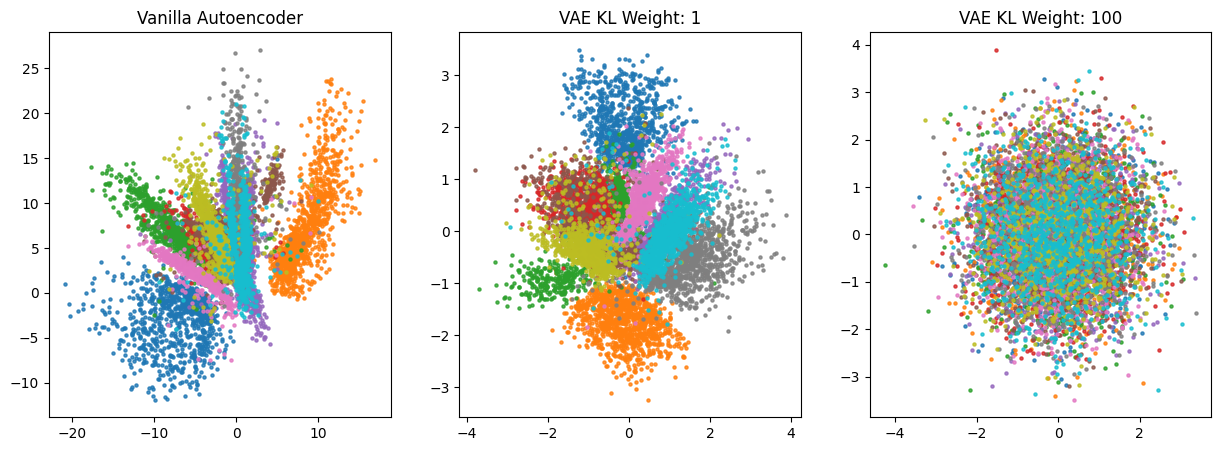

In [76]:
model_latents = [x[-1] for x in encoded_datas]
model_names = ["Vanilla Autoencoder", "VAE KL Weight: 1", "VAE KL Weight: 100"]

fig, ax = plt.subplots(1,3, figsize=(15,5))

for idx, encoding in enumerate(model_latents):
    encoding = pd.DataFrame(encoding, columns=["x", "y", "class"])
    encoding = encoding.sort_values(by="class")
    encoding["class"] = encoding["class"].astype(int).astype(str)
    
    for grouper, group in encoding.groupby("class"):
        ax[idx].scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)
        ax[idx].set_title(model_names[idx])

### Grab Models for Future Visualization ###
vanilla_ae, vae, _ = models 

### Interpolate the Latent Space

Lets interpolate the latent space and see the quality of transitions between digit classes! (The function was just imported from Utils but we made it in the Vanilla Autoencoder Tutorial!)

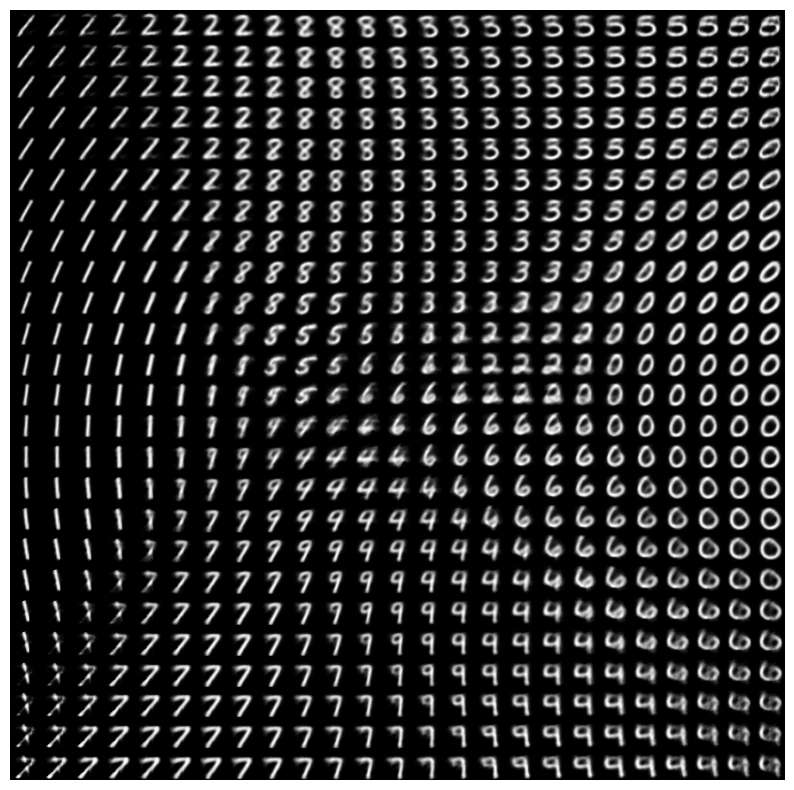

In [78]:
### Pass in the different models we made too see reconstruction!
interpolate_space(vae, (-2,2), (-2,2))

### Generating New Data!

If we want to generate new data from our VAE, all we have to do is pass gaussian noise to the decoder and let it create a new sample!

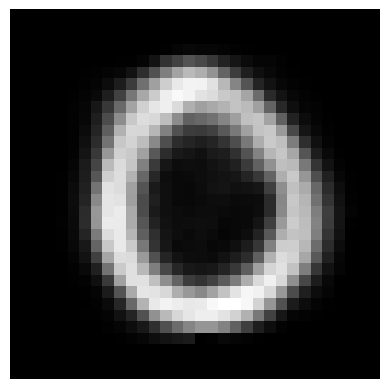

In [108]:
### Generate Noise and Pass through Decoder ###
noise = torch.randn((1,2)).to(device)

with torch.no_grad():
    generated = vae.forward_dec(noise)

### Reshape Generated Back to Image Shape and Display ###
generated = generated.cpu().reshape(32,32).numpy()

plt.imshow(generated, cmap="gray")
plt.axis("off")
plt.show()


### Lets Build A Convolutional Variational AutoEncoder!

Convolutional VAE will be basically the same thing, expect we aren't going to use any linear layers. Remember from our last tutorial on basic Autoencoders, when we wrote the Convolutional AutoEncoder, our image of 1024 pixels are compressed down into a 4 channel x 4 height x 4 width feature cube. Like we had two new linear layers to map the output of our encoder to $\mu$ and $\sigma$, we will have two new convolutional layers to do the same! We can treat our latent dimension to be a random cube sampled from a gaussian distribution. 

In [153]:
class ConvolutionalVAE(nn.Module):
    def __init__(self, in_channels=1, channels_bottleneck=4):
        super().__init__()

        self.bottleneck = channels_bottleneck
        self.in_channels = in_channels 
        
        self.encoder_conv = nn.Sequential(

            ### Convolutional Encoding ###
            nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=5, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(8),
            nn.ReLU(), 

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(16),
            nn.ReLU(), 

            nn.Conv2d(in_channels=16, out_channels=self.bottleneck, kernel_size=3, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(self.bottleneck),
            nn.ReLU(),

            
        )

        #########################################################
        ### The New Layers Added in from Original AutoEncoder ###
        self.conv_mu =  nn.Conv2d(in_channels=self.bottleneck, out_channels=self.bottleneck, kernel_size=3, stride=1, padding="same")
        self.conv_logvar = nn.Conv2d(in_channels=self.bottleneck, out_channels=self.bottleneck, kernel_size=3, stride=1, padding="same")
        #########################################################

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.bottleneck, out_channels=16, kernel_size=3, stride=2, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(), 
            
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=8, out_channels=in_channels, kernel_size=2, stride=2, padding=1),
            nn.Sigmoid()
        )
    

    def forward_enc(self, x):
        batch_size, num_channels, height, width = x.shape
        conv_enc = self.encoder_conv(x)

        #############################################
        ### Compute Mu and Sigma ###
        mu = self.conv_mu(conv_enc)
        logvar = self.conv_logvar(conv_enc)
        
        ### Sample with Reparamaterization Trick ###
        sigma = torch.exp(0.5*logvar)
        noise = torch.randn_like(sigma, device=sigma.device)
        z = mu + sigma*noise
        ############################################
        
        return z, mu, logvar

    def forward_dec(self, x):
        batch_size = x.shape[0]
        x = x.reshape((batch_size, self.bottleneck, 4, 4))
        conv_dec = self.decoder_conv(x)
        return conv_dec
        
    def forward(self, x):
        batch_size, num_channels, height, width = x.shape
        z, mu, logvar = self.forward_enc(x)
        dec = self.forward_dec(z)
        return z, dec, mu, logvar

### Train ConvAE ###
conv_ae_model = ConvolutionalAutoEncoder()
conv_ae_model, train_losses, evaluation_losses, conv_ae_encoded_data_per_eval = train(conv_ae_model,
                                                                                      kl_weight=None,
                                                                                      train_set=train_set,
                                                                                      test_set=test_set,
                                                                                      batch_size=64,
                                                                                      training_iterations=30000,
                                                                                      evaluation_iterations=250,
                                                                                      model_type="AE")


### Train ConvVAE
conv_vae_model = ConvolutionalVAE()
conv_vae_model, train_losses, evaluation_losses, conv_vae_encoded_data_per_eval = train(conv_vae_model,
                                                                                        kl_weight=0.8,
                                                                                        train_set=train_set,
                                                                                        test_set=test_set,
                                                                                        batch_size=64,
                                                                                        training_iterations=30000,
                                                                                        evaluation_iterations=250,
                                                                                        model_type="VAE")


  0%|          | 0/30000 [00:00<?, ?it/s]

Completed Training!
Final Training Loss 0.00416973521001637
Final Evaluation Loss 0.004043340171349182


  0%|          | 0/30000 [00:00<?, ?it/s]

Completed Training!
Final Training Loss 43.20465055847168
Final Evaluation Loss 43.08606586334812


### Lets Plot the Latents with TSNE!

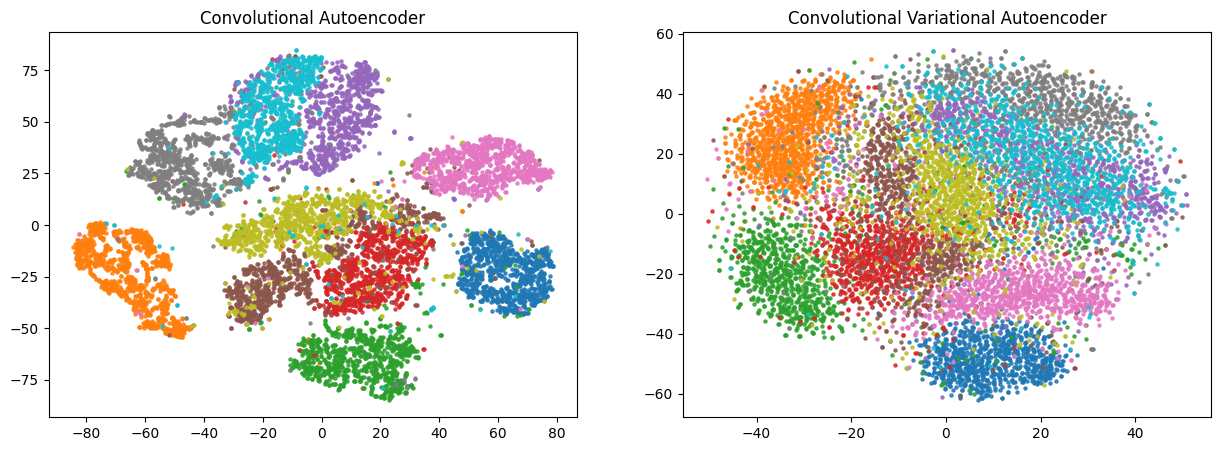

In [154]:
### TSNE Compression of ConvAE ###
conv_ae_encoding = conv_ae_encoded_data_per_eval[-1]
conv_ae_features, conv_ae_labels = conv_ae_encoding[:,:-1], conv_ae_encoding[:, -1].reshape(-1,1)
tsne = TSNE(2, n_jobs=-1)
conv_ae_compressed = tsne.fit_transform(X=conv_ae_features)

conv_ae_encoding = np.hstack((conv_ae_compressed, conv_ae_labels))
conv_ae_encoding = pd.DataFrame(conv_ae_encoding, columns=["x", "y", "class"])
conv_ae_encoding = conv_ae_encoding.sort_values(by="class")
conv_ae_encoding["class"] = conv_ae_encoding["class"].astype(int).astype(str)

### TSNE Compression of ConvVAE ###
conv_vae_encoding = conv_vae_encoded_data_per_eval[-1]
conv_vae_features, conv_vae_labels = conv_vae_encoding[:,:-1], conv_vae_encoding[:, -1].reshape(-1,1)
tsne = TSNE(2, n_jobs=-1)
conv_vae_compressed = tsne.fit_transform(X=conv_vae_features)

conv_vae_encoding = np.hstack((conv_vae_compressed, conv_vae_labels))
conv_vae_encoding = pd.DataFrame(conv_vae_encoding, columns=["x", "y", "class"])
conv_vae_encoding = conv_vae_encoding.sort_values(by="class")
conv_vae_encoding["class"] = conv_vae_encoding["class"].astype(int).astype(str)

### Plot Compression! ###
fig, ax = plt.subplots(1,2,figsize=(15,5))

for grouper, group in conv_ae_encoding.groupby("class"):
    ax[0].scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)

for grouper, group in conv_vae_encoding.groupby("class"):
    ax[1].scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)

ax[0].set_title("Convolutional Autoencoder")
ax[1].set_title("Convolutional Variational Autoencoder")

plt.show()

### Taking a Closer look at Reconstruction

Although VAE's have a nice latent space, we fall into another problem, blurring. 



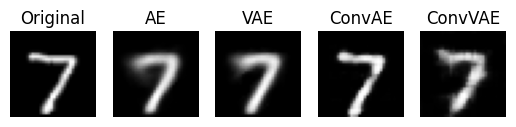

In [156]:
generated_index = 0
image, label = test_set[generated_index]
image = image.unsqueeze(0).to(device)

_, ae_reconstructed = vanilla_ae(image)
_, vae_reconstructed, _, _ = vae(image)
_, conv_ae_reconstructed = conv_ae_model(image)
_, conv_vae_reconstructed, _, _ = conv_vae_model(image)


image = image.to("cpu")
ae_reconstructed = ae_reconstructed.to("cpu").detach().numpy()
vae_reconstructed = vae_reconstructed.to("cpu").detach().numpy()
conv_ae_reconstructed = conv_ae_reconstructed.to("cpu").detach().numpy()
conv_vae_reconstructed = conv_vae_reconstructed.to("cpu").detach().numpy()

fig, ax = plt.subplots(1,5)

ax[0].imshow(image.squeeze(), cmap="gray")
ax[0].set_title("Original")
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].axis("off")

ax[1].imshow(ae_reconstructed.squeeze(), cmap="gray")
ax[1].set_title("AE")
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].axis("off")

ax[2].imshow(vae_reconstructed.squeeze(), cmap="gray")
ax[2].set_title("VAE")
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].axis("off")

ax[3].imshow(conv_ae_reconstructed.squeeze(), cmap="gray")
ax[3].set_title("ConvAE")
ax[3].set_xticklabels([])
ax[3].set_yticklabels([])
ax[3].axis("off")

ax[4].imshow(conv_vae_reconstructed.squeeze(), cmap="gray")
ax[4].set_title("ConvVAE")
ax[4].set_xticklabels([])
ax[4].set_yticklabels([])
ax[4].axis("off")


plt.show()


As you can see, it looks like the reconstructions of the VAE are slightly more blurry compared to a regular autoencoder. Due to the regularized nature of our latent space, we have forced smooth transitions between different classes. Lets pretend we trained a VAE on Dogs vs Cats. Does it make sense to have representations that are a mixture of dogs and cats? Not really, our goal is to generate dogs or cats, not some weird hybrid of the two. So in this case, we would need to give an opportunity to discretize the latent space in some way. 

### Vector Quantized Variational AutoEncoders
In comes quantization! If you have never heared the term quantization before, it is used everywhere, especially in signal processing. We will dig into this in the next tutorial, but the high level understanding is, instead of learning latents that are continuous, we want to instead map our continuous latents to some discrete ones. By doing this, we should be able to promote the separation of classes better while also maintaining the rest of our restrictions like mapping to a gaussian. 